In [1]:
import os
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
import numpy as np

In [2]:
import os
from transformers import AutoTokenizer, AutoModel
import torch
import faiss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Función para leer archivos de texto
def read_text_files(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith(".md"):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                documents.append(file.read())
    return documents

# Función para dividir el texto en chunks
def chunk_text(text, chunk_size=100):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

# Función para generar embeddings
def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Cargar el modelo y el tokenizer
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Leer documentos de texto
directory = "./resources/knowledge-base/employees"
documents = read_text_files(directory)

# Verificar que se leyeron documentos
if not documents:
    raise ValueError("No se encontraron documentos en el directorio especificado.")

# Dividir documentos en chunks y generar embeddings
chunks = []
for doc in documents:
    doc_chunks = chunk_text(doc)
    chunks.extend(doc_chunks)

embeddings = [generate_embeddings(chunk) for chunk in chunks]

# Verificar que se generaron embeddings
if not embeddings:
    raise ValueError("No se generaron embeddings para los chunks.")

# Convertir embeddings a formato numpy array y asegurar que es una matriz 2D
embeddings_array = np.array(embeddings).astype('float32')
if len(embeddings_array.shape) == 1:
    embeddings_array = embeddings_array.reshape(-1, embeddings_array.shape[0])

# Crear un índice FAISS
dimension = embeddings_array.shape[1]  # Dimensión de los vectores (depende del modelo de embeddings)
index = faiss.IndexFlatL2(dimension)  # Usar L2 como métrica de distancia

# Añadir los vectores al índice
index.add(embeddings_array)

# Almacenar los chunks con sus embeddings
chunks_with_embeddings = [{"text": chunk, "embedding": emb} for chunk, emb in zip(chunks, embeddings)]

# Función para realizar búsquedas
def search(query_text, top_k=5):
    query_embedding = generate_embeddings(query_text).astype('float32')
    distances, indices = index.search(np.array([query_embedding]), top_k)
    results = [{"text": chunks_with_embeddings[idx]["text"], "distance": dist} for dist, idx in zip(distances[0], indices[0])]
    return results


In [6]:
# Ejemplo de búsqueda
query_text = "hobbies"
results = search(query_text, top_k=5)
for result in results:
    print(f"Texto: {result['text']}, Distancia: {result['distance']}")

Texto: - **Personal Interests:** Has a keen interest in hiking and photography, often sharing his photography from weekend hikes with colleagues, fostering positive team relationships., Distancia: 37.5746955871582
Texto: community outreach programs, representing Insurellm in charity events to promote corporate social responsibility. - **Interests:** In her spare time, Emily enjoys hiking, photography, and volunteering at local animal shelters. - **Team Feedback:** Colleagues describe Emily as a highly motivated team player who consistently uplifts everyone around her. Emily Carter exemplifies the kind of talent that drives Insurellm's success and is an invaluable asset to the company., Distancia: 42.147220611572266
Texto: Notes - **Training Completed**: - Advanced Digital Marketing Workshop (2021) - Analytics and Reporting in Digital Advertising (2022) - **Professional Development Goals**: - Emily Tran aims to become a Marketing Manager within the next two years, focusing on leading la

C:\Users\MANGUTI\AppData\Local\anaconda3\envs\llms\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


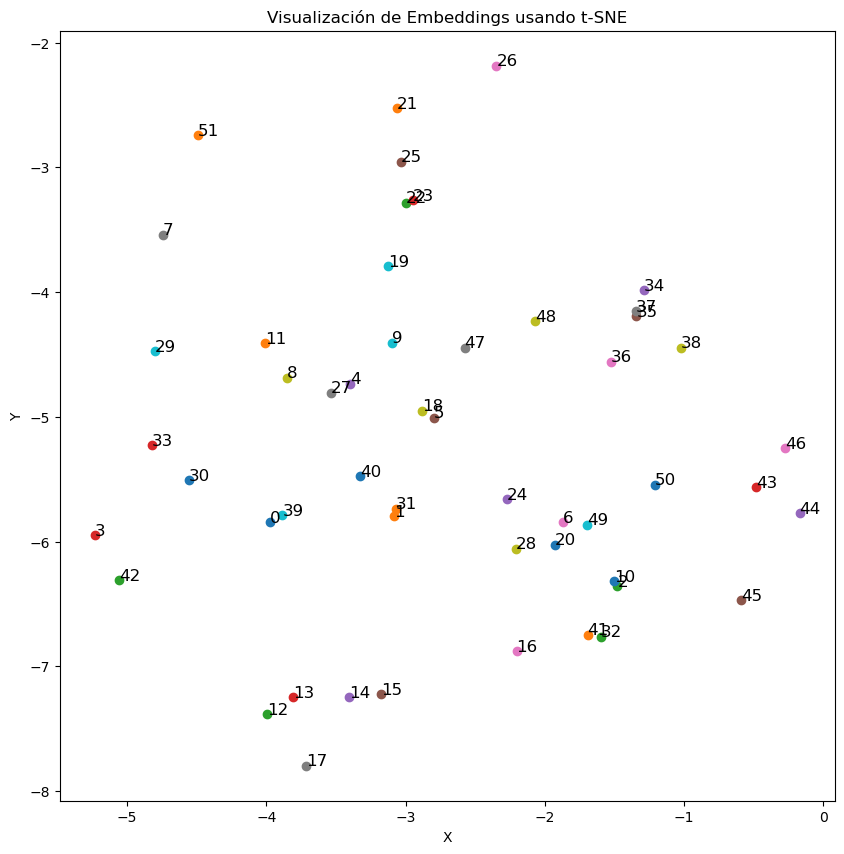

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, documents):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ajustar perplexity para que sea menor que n_samples
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 10))
    for i, (x, y) in enumerate(reduced_embeddings):
        plt.scatter(x, y)
        plt.text(x, y, str(i), fontsize=12)
    plt.title("Visualización de Embeddings usando t-SNE")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

# Visualizar los embeddings
visualize_embeddings(embeddings_array, documents)